In [15]:
# IMPORT ALL THE LIBRARIES USED IN THE NOTEBOOK
import math
import plotly.subplots as psu
import matplotlib.pyplot as plt
from waffles.data_classes.WaveformSet import WaveformSet
from waffles.data_classes.Waveform import Waveform
import numpy as np
from waffles.input.pickle_file_to_WaveformSet import pickle_file_to_WaveformSet
from glob import glob

plt.rcParams.update({
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     })

In [23]:
import re
ch = 11114
filesresponse = sorted(glob(f'/eos/home-h/hvieirad/waffles/analysis/templates/*_ch{ch}.pkl'))
p = re.compile("run0([0-9]+)_ch([0-9]+)pkl")
wfsets = {}
for f in filesresponse:
    m = p.search(f)
    try:
        run = int(m.group(1))
    except:
        run = 0
        print(f)
    wfset = pickle_file_to_WaveformSet(f)
    wfsets[run] = wfset
    if run != 0:
        if run <27901:
            dstack = 'stack'
        else:
            dstack = 'stack1'
        if dstack not in wfsets.keys():
            wfsets[dstack] = [ [ wvf.adcs, wvf.baseline ] for wvf in wfset.waveforms ]
        else:
            wfsets[dstack]+=[ [ wvf.adcs, wvf.baseline ] for wvf in wfset.waveforms ]
            
    print(run, len(wfset.waveforms), wfset.nselected)


0 1 28266
1 1 71978
26081 4685 4685
26253 4714 4714
26261 4820 4820
26315 4509 4509
26360 4767 4767
26376 4771 4771
28624 10277 10277
28993 20638 20638
29177 20438 20438
29319 20625 20625


4000
4000


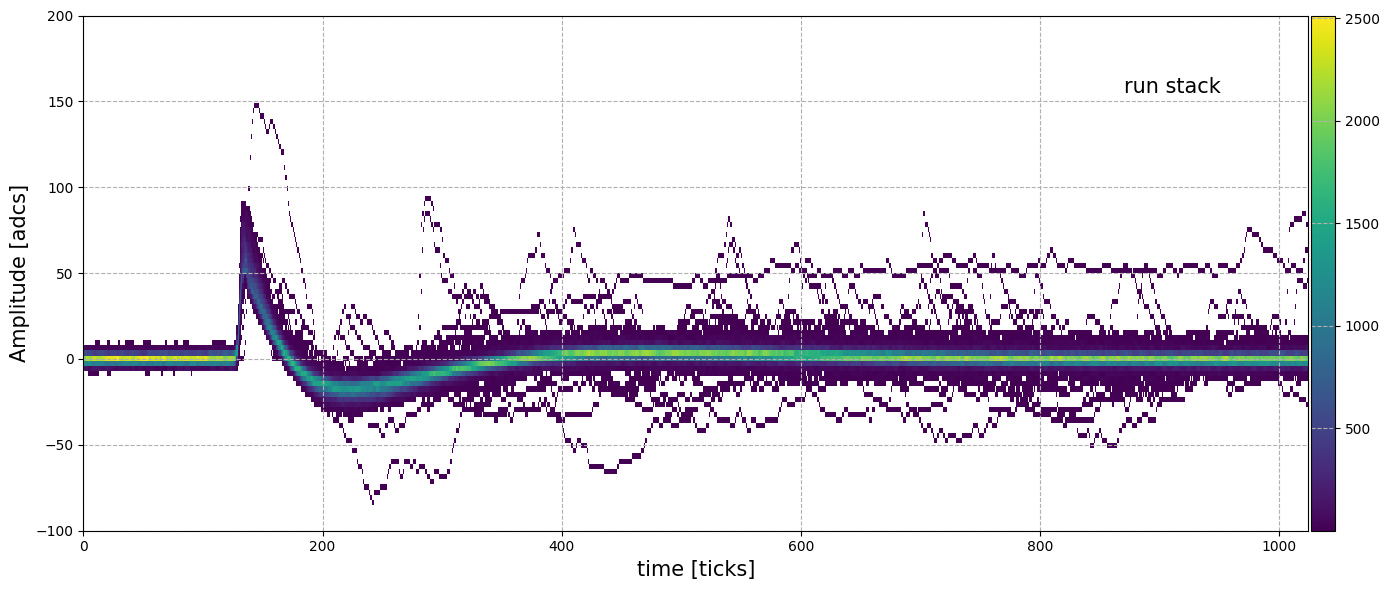

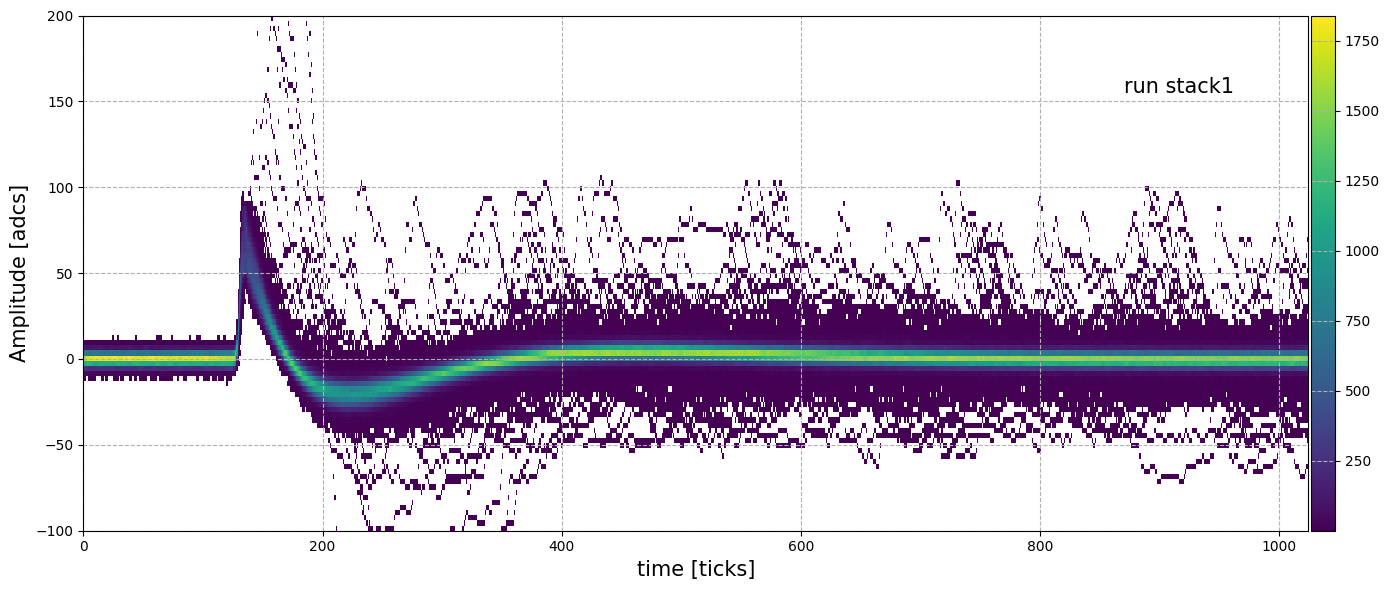

In [17]:
import ctypes
from waffles.utils.denoising.tv1ddenoise import Denoise
denoiser = Denoise()
def persistence_plot(wfset_ch:WaveformSet, runnumber:int):

    filtering=2
    if isinstance(wfset_ch,list):
        filtered_wvfs = [ denoiser.apply_denoise(wvf[0], filtering) for wvf in wfset_ch]
        times = np.linspace(0, len(wfset_ch[0][0]),len(wfset_ch[0][0]))
        time_arrays = np.tile(times, (len(wfset_ch), 1))
        wvf_arrays = np.array([(wvf - baseline[1])*-1 for wvf, baseline in zip(filtered_wvfs, wfset_ch)])
    else:
        filtered_wvfs = [ denoiser.apply_denoise(wvf.adcs, filtering) for wvf in wfset_ch.waveforms ]
        times = np.linspace(0, len(wfset_ch.waveforms[0].adcs),len(wfset_ch.waveforms[0].adcs))
        time_arrays = np.tile(times, (len(wfset_ch.waveforms), 1))
        wvf_arrays = np.array([(wvf - waveform.baseline)*-1 for wvf, waveform in zip(filtered_wvfs, wfset_ch.waveforms)])
    maxofall = np.max(wvf_arrays)*1.1
    minofall = np.min(wvf_arrays)*1.1
    maxofall = 200
    minofall = -60
    minofall = -1*maxofall/2
    
    
    time_arrays = time_arrays[:4000]
    wvf_arrays = wvf_arrays[:4000]
    print(len(wvf_arrays))
    h, yedges, xedges = np.histogram2d(wvf_arrays.flatten(), time_arrays.flatten(), bins=(int(maxofall+minofall),1024), range = [[minofall,maxofall],[0,1024]])
    h[h==0] = np.nan
    fig, ax = plt.subplots(1, 1, figsize=(14,6))

    x, y = np.meshgrid(xedges, yedges)
    pcm = ax.pcolormesh(x, y, h)
    ax.set_ylabel("Amplitude [adcs]", fontsize=15)
    ax.set_xlabel("time [ticks]", fontsize=15)
    cax = ax.inset_axes([1.002, 0., 0.02, 1.])
    plt.colorbar(pcm, ax=ax, cax=cax)
    plt.text(0.85,0.85,f'run {runnumber}', transform=ax.transAxes, fontsize=15)

    # avgwvf = wfset_ch.avgwvf
    # plt.plot(avgwvf, '--k', lw=1)
    # plt.xlim(120,200)
    # plt.xlim(160,300)
    # plt.ylim(-20,100)
    # plt.ylim(-40,20)


# for r, wf in list(wfsets.items())[None:]:
#     persistence_plot(wf,r)
    # plt.savefig(f'./graphs/template_check/run0{r}_ch{ch}.png')
# persistence_plot(wfsets[26261], 26261)
# persistence_plot(wfsets[29177], 29177)
# persistence_plot(wfsets[28624], 28624)
# persistence_plot(wfsets[28993], 28993)
# persistence_plot(wfsets[29319], 29319)
persistence_plot(wfsets['stack'], 'stack')
persistence_plot(wfsets['stack1'], 'stack1')


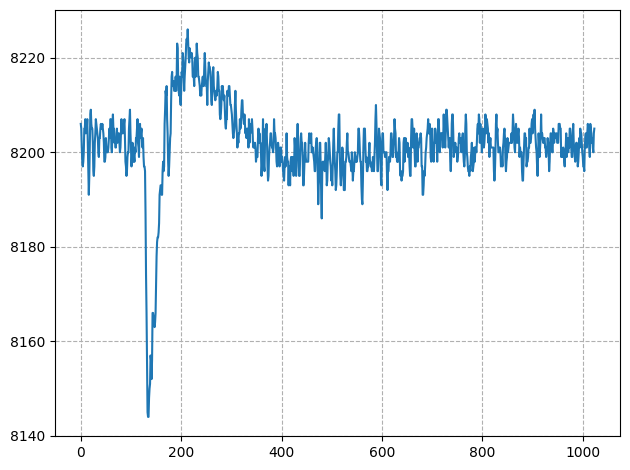

In [29]:
idx=0
plt.plot(wfsets[29177].waveforms[idx].adcs)

Text(0.5, 0, 'Time [ticks]')

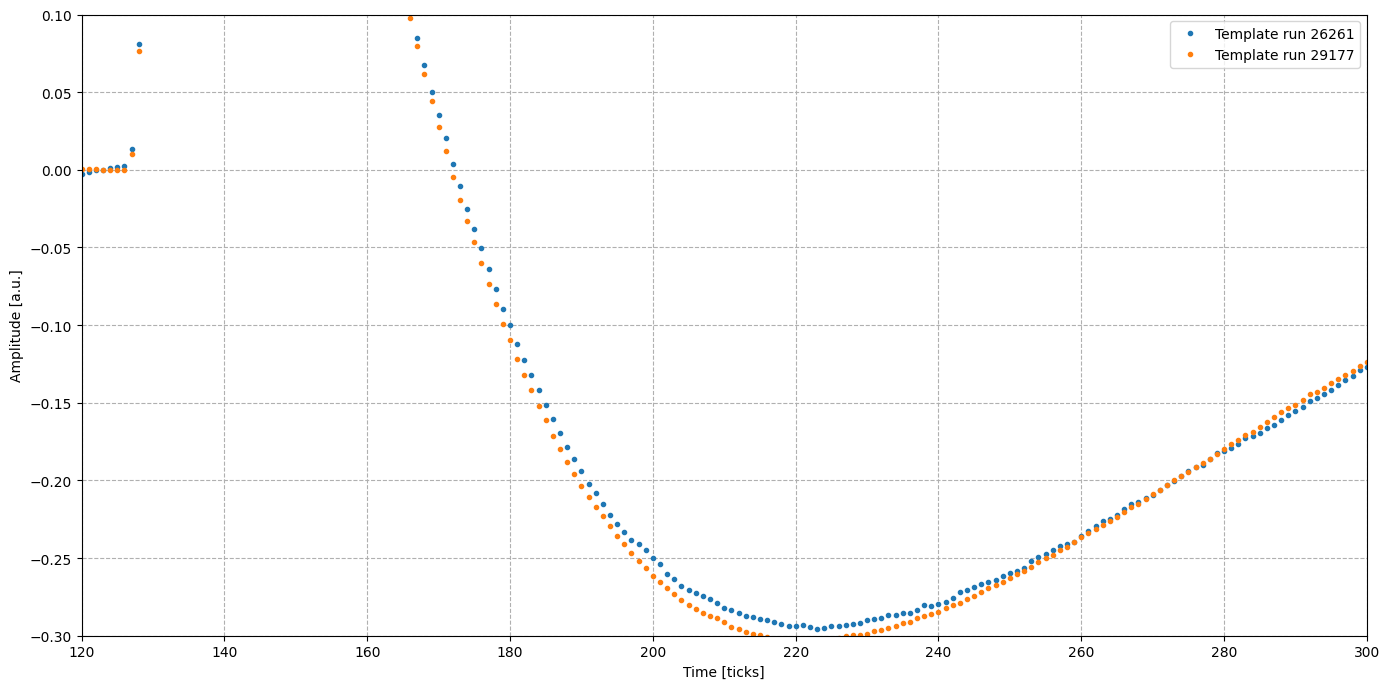

In [11]:
plt.figure(figsize=(14,7))
# for r, wf in wfsets.items():
#     plt.plot(wf.avgwvf/np.max(wf.avgwvf), label=r)
plt.plot(wfsets[0].avgwvf/np.max(wfsets[0].avgwvf), '.',label='Template run 26261')
plt.plot(wfsets[29177].avgwvf/np.max(wfsets[29177].avgwvf), '.',label='Template run 29177')
plt.legend()
    
plt.xlim(120,300)
plt.ylim(-0.3,0.1)
plt.ylabel('Amplitude [a.u.]')
plt.xlabel('Time [ticks]')


In [57]:
import plotly.graph_objects as go
import plotly.io as pio
id1 = 0
id2 = 1
fig = go.Figure()
ytest = 1-( wfsets[id2].avgwvf/np.max(wfsets[id2].avgwvf) )/(wfsets[id1].avgwvf/np.max(wfsets[id1].avgwvf))
fig.add_trace(go.Scatter(y=wfsets[id1].avgwvf/np.max(wfsets[id1].avgwvf), mode='markers', name='stack1'))
fig.add_trace(go.Scatter(y=wfsets[id2].avgwvf/np.max(wfsets[id2].avgwvf), mode='markers', name='stack2'))
fig.add_trace(go.Scatter(y=ytest, mode='markers', name='relative diff'))
fig.update_layout(
    xaxis_title="Ticks",
    yaxis_title="Normalized amplitude",
    yaxis_range=[-.4,1.2],
    # yaxis_range=[-.4,0.2],
    # xaxis_range=[100, 700],
    height = 600,
    width = 1600,
)
fig.show()
fig.write_image("./graphs/compare_templates.png", scale=3, height = 300*2, width = 300*5)

In [173]:
refs = np.array([ np.max( (( denoiser.apply_denoise(wvf.adcs - wvf.baseline, 10))*(-1) )[134:138]) for wvf in wfsets[29177].waveforms ])

np.where(refs>130)

(array([], dtype=int64),)

In [249]:
fig = go.Figure()
run=29177
filtering=14
startp = None
endp = None
idx+=1
fig.add_trace(go.Scatter(y=((wfsets[run].waveforms[idx].adcs - wfsets[run].waveforms[idx].baseline)*-1)[startp:endp], mode='markers', name='sample'))
fig.add_trace(go.Scatter(y=(denoiser.apply_denoise(wfsets[run].waveforms[idx].adcs - wfsets[run].waveforms[idx].baseline, 14)*-1)[startp:endp], mode='markers', name='filtered'))

In [14]:
import plotly.graph_objects as go

fig = go.Figure()

for r, wf in list(wfsets.items())[-4:]:
    if r == 'stack': continue
    fig.add_trace(go.Scatter(y=wf.avgwvf/np.max(wf.avgwvf), mode='markers', name=r))
# fig.update_layout(yaxis_range=[-.4,1.2])
fig.show()